<a href="https://colab.research.google.com/github/AbdullaOvais/LO/blob/main/Assignment2_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Assignment: 2

# Linear Optimization
**Subject Code**: CS5040  


---


**CS24MTECH12014** : Abdulla Ovais



---

### Assumptions:
1. Initial feasible point is given

---

Implement the simplex algorithm to maximize the objective function, You need to implement the method discussed in class.

---

### Input:
- CSV file with `m + 2` rows and `n + 1` columns.
  - The **first row**, excluding the last element, is the initial feasible point `z` of length `n`.
  - The **second row**, excluding the last element, is the cost vector `c` of length `n`.
  - The **last column**, excluding the top two elements, is the constraint vector `b` of length `m`.
  - **Rows third** to m+2 and **column one** to n is the matrix A of size m*n.

---

### Output:
You need to print the sequence of vertices visited and the value of the objective function at that vertex.

---

### Instructions:
1. You need to implement in google Collab and share the link
2. Implementation language is Python
3. Input CSV file name is Testcase.csv from Collab workspace.

Vertex: [ 3. -1.  3.] | Objective Value: 10.0000
Vertex: [-1.  3.  3.] | Objective Value: 14.0000

 Optimization complete.

 Sequence of vertices visited:
  Step 1: Vertex [ 3. -1.  3.] | Objective Value: 10.0000
  Step 2: Vertex [-1.  3.  3.] | Objective Value: 14.0000


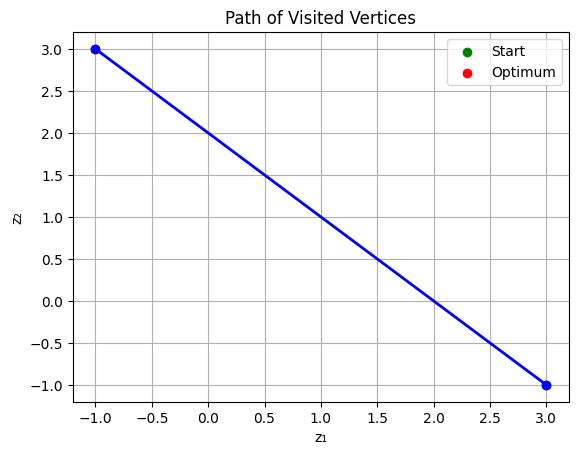

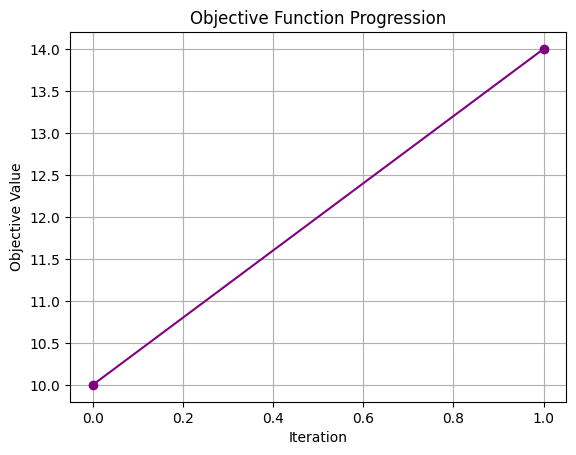

In [132]:
import numpy as np
from sympy import Matrix
import matplotlib.pyplot as plt

class MyAlgo:
    """
    Custom implementation of the Simplex algorithm for linear programming
    (maximization form), assuming:
        1. Polytope is non-degenerate
        2. Polytope is bounded
        3. Rank(A) = number of columns
        4. Initial feasible point is provided
    """

    def __init__(self, filename):
        data = np.genfromtxt(filename, delimiter=',')
        self.z = data[0, :-1]           # initial feasible point,take only 1st row exclude last element
        self.c = data[1, :-1]           # cost vector,take only 2nd row exclude last element
        self.A = data[2:, :-1]          # constraint matrix,from 3rd row to last row but take all column except last column
        self.b = data[2:, -1]           # constraint vector,from 3rd row to last row but take only last column excluding top 2 elements
        self.path = []              # Store (vertex, objective)
        np.set_printoptions(precision=4, suppress=True)

    # ---------- Constraint sets ----------
    def tight_constraints(self):
        mask = np.isclose(self.A @ self.z, self.b, atol=1e-8)
        return self.A[mask], self.b[mask]

    def loose_constraints(self):
        mask = ~np.isclose(self.A @ self.z, self.b, atol=1e-8)
        return self.A[mask], self.b[mask]

    # ---------- Optimality check ----------
    def is_optimal(self):
        A_t, _ = self.tight_constraints()
        if A_t.shape[0] == 0:
            return False
        lambdas = np.linalg.pinv(A_t.T) @ self.c
        return np.all(lambdas >= -1e-10)

    # ---------- Improving direction ----------
    def improving_direction(self):
        A_t, _ = self.tight_constraints()
        if A_t.shape[0] == 0:
            return None
        A_t_inv_T = np.linalg.pinv(A_t).T
        for row in A_t_inv_T:
            if np.dot(-row, self.c) > 0:
                return row
        return None

    # ---------- Step size computation ----------
    def step_size(self, d):
        A_l, b_l = self.loose_constraints()
        if A_l.shape[0] == 0:
            return np.inf   # No constraints ⇒ unbounded
        denom = A_l @ d
        denom = np.where(np.abs(denom) < 1e-12, 1e-12, denom)
        alphas = (A_l @ self.z - b_l) / denom
        valid = [a for a in alphas if a >= 1e-10]
        if not valid:
            return np.inf   # No limit along this direction ⇒ unbounded
        return min(valid)

    # ---------- Move to vertex if needed ----------
    def move_to_vertex_if_needed(self, max_iter=100):
        """Ensure the starting point lies on a vertex (n tight constraints)."""
        for _ in range(max_iter):
            A_t, _ = self.tight_constraints()
            if A_t.shape[0] >= len(self.z):
                return True  # Vertex found
            ns = Matrix(A_t).nullspace() if A_t.size > 0 else [np.eye(len(self.z))[0]]
            d = np.array(ns[0]).astype(float).flatten()
            d /= np.linalg.norm(d) + 1e-12
            A_l, b_l = self.loose_constraints()
            denom = A_l @ d
            denom = np.where(np.abs(denom) < 1e-12, 1e-12, denom)
            alphas = (b_l - A_l @ self.z) / denom
            valid = [a for a in alphas if a > 1e-12]
            if not valid:
                print(" No solution — the problem is unbounded.")
                return False
            alpha = min(valid)
            self.z = self.z + alpha * d
        print(" No solution due to unbounded region .")
        return False

    # ---------- Main Simplex Algorithm ----------
    def solve(self):
        if not np.all(self.A @ self.z <= self.b + 1e-10):
            print(" Given point is not feasible. Please provide a feasible starting point.")
            return

        # Move to a vertex if not already one
        if not self.move_to_vertex_if_needed():
            return  # Unbounded — already detected

        # Record initial vertex
        value = np.dot(self.c, self.z)
        self.path.append((self.z.copy(), value))
        print(f"Vertex: {self.z} | Objective Value: {value:.4f}")

        iteration = 1
        while not self.is_optimal():
            d = self.improving_direction()
            if d is None:
                print("No improving direction found (possible optimal vertex).")
                break
            alpha = self.step_size(d)
            if np.isinf(alpha) or alpha > 1e10:
                print(" No solution — the problem is unbounded.")
                return
            if alpha <= 1e-12:
                print(" Degenerate or zero step detected — stopping.")
                break
            # Move to new vertex
            self.z = self.z - alpha * d
            value = np.dot(self.c, self.z)
            self.path.append((self.z.copy(), value))
            print(f"Vertex: {self.z} | Objective Value: {value:.4f}")
            iteration += 1

        print("\n Optimization complete.")
        self.print_summary()

    # ---------- Summary ----------
    def print_summary(self):
        if not self.path:
            print("No feasible or bounded solution found.")
            return
        print("\n Sequence of vertices visited:")
        for i, (z, val) in enumerate(self.path):
            print(f"  Step {i+1}: Vertex {z} | Objective Value: {val:.4f}")
        optimal_vertex, optimal_value = max(self.path, key=lambda x: x[1])


    # ---------- Plotting ----------
    def plot_vertices(self):
        if len(self.path) < 2:
            print("Not enough vertices to plot.")
            return
        points = np.array([p[0] for p in self.path])
        plt.plot(points[:, 0], points[:, 1], 'bo-', linewidth=2)
        plt.scatter(points[0, 0], points[0, 1], color='green', label='Start')
        plt.scatter(points[-1, 0], points[-1, 1], color='red', label='Optimum')
        plt.xlabel('z₁')
        plt.ylabel('z₂')
        plt.title('Path of Visited Vertices')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_objective(self):
        if not self.path:
            return
        values = [v for _, v in self.path]
        plt.plot(range(len(values)), values, 'o-', color='purple')
        plt.xlabel('Iteration')
        plt.ylabel('Objective Value')
        plt.title('Objective Function Progression')
        plt.grid(True)
        plt.show()


# ---------------------- MAIN ----------------------
if __name__ == "__main__":
    simplex = MyAlgo("Testcase_2.csv")  # You uploaded file here
    simplex.solve()
    simplex.plot_vertices()
    simplex.plot_objective()
